# Chi-Squared Test for Dummies

If you search the Wikipedia definition of Chi-Squared test, you get the following definition:

> Pearson's chi-squared test $\chi^2$ is a statistical test applied to sets of categorical data to evaluate how likely it is that any observed difference between the sets arose by chance. 

What does it mean? Let's see it together.

## Example 1: is a dice fair?

Suppose you want to test whether a dice is fair. 

You throw the dice 60 times and you count the number of times you get each outcome. 

Let's simulate some data (from a fair dice).

In [1]:
import numpy as np
import pandas as pd

# Data generating process
def generate_data_dice(N=60, seed=1):
    np.random.seed(1) # Set seed for replicability
    dice_numbers = [1,2,3,4,5,6]  # Dice numbers
    dice_throws = np.random.choice(dice_numbers, size=N)  # Actual dice throws
    data = pd.DataFrame({"dice number": dice_numbers,
                         "observed": [sum(dice_throws==n) for n in dice_numbers],
                         "expected": N / 6})
    return data

In [2]:
# Generate data
data_dice = generate_data_dice()
data_dice

,dice number,observed,expected
0,1,10,10.0
1,2,14,10.0
2,3,6,10.0
3,4,8,10.0
4,5,12,10.0
5,6,10,10.0


If we were throwing the dice **a lot** of times, we would expect the same number of observations for each outcome. However, there is inherent noise in the process. How can we tell whether the fact that we didn't get exactly 10 observations for each outcome is just due to randomness or it's because the dice is unfair?

The idea is to compute some statistic whose distribution is known under the assumption that the dice is fair, and then check if its value is "unusual" or not. If the value is particularly "unusual", we reject the null hypothesis that the dice is fair.

In our case, the statistic we choose is the chi-squared $\chi^{2}$ test-statistic.

The value of the [Pearson's chi-squared test-statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test) is

$$
T_{\chi^2} = \sum _{i=1}^{n} \frac{(O_i - E_i)^{2}}{E_i} = N \sum _{i=1}^{n} \frac{\left(O_i/N - p_i \right)^2 }{p_i}
$$

where

- $O_{i}$ = the number of observations of type i.
- $N$ = total number of observations
- $E_{i}=Np_{i}$ = the expected (theoretical) count of type $i$, asserted by the null hypothesis that the fraction of type $i$ in the population is $p_{i}$
- $n$ = the number of cells in the table.

In [3]:
# Compute value of the statistic
def compute_chi2_stat(data):
    return sum( (data.observed - data.expected)**2 / data.expected )

chi2_stat = compute_chi2_stat(data_dice)
chi2_stat

4.0

What do we make of this number? Is it "unusual"?

If the dice were fair, the test Pearson's chi-squared test-statistic $T_{\chi^2}$ is distributed as a chi-squared distribution with $k-1$ degrees of freedom, $\chi^2_{k-1}$. For the moment, take this claim at face value, we will verify it later, both empirically and theoretically. We will also discuss the degrees of freedom in detail later on.

**Important!** Do not confuse the chi-squared test statistic (a number) with the chi-squared distribution (a distribution).

What does a chi-squared distribution with $n-1$ degrees of freedom, $\chi^2_{k-1}$, look like?

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from src.utils import *

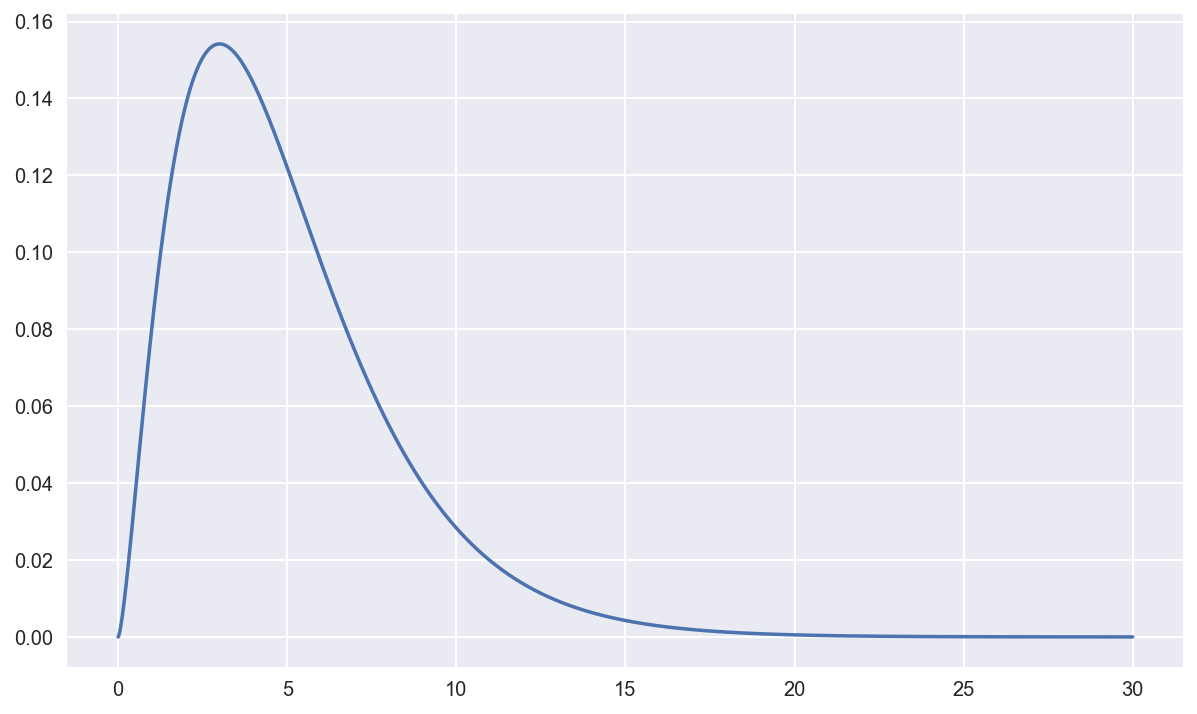

In [5]:
from scipy.stats import chi2

# x-axis ranges from 0 to 20 with .001 steps
x = np.arange(0, 30, 0.001)

# Chi-square distribution with 5 degrees of freedom
chi2_5_pdf = chi2.pdf(x, df=5)

# Plot 
plt.plot(x, chi2_5_pdf);

How does the value of the statistic we have observed compares with its the distribution under the null hypothesis of a fair dice?

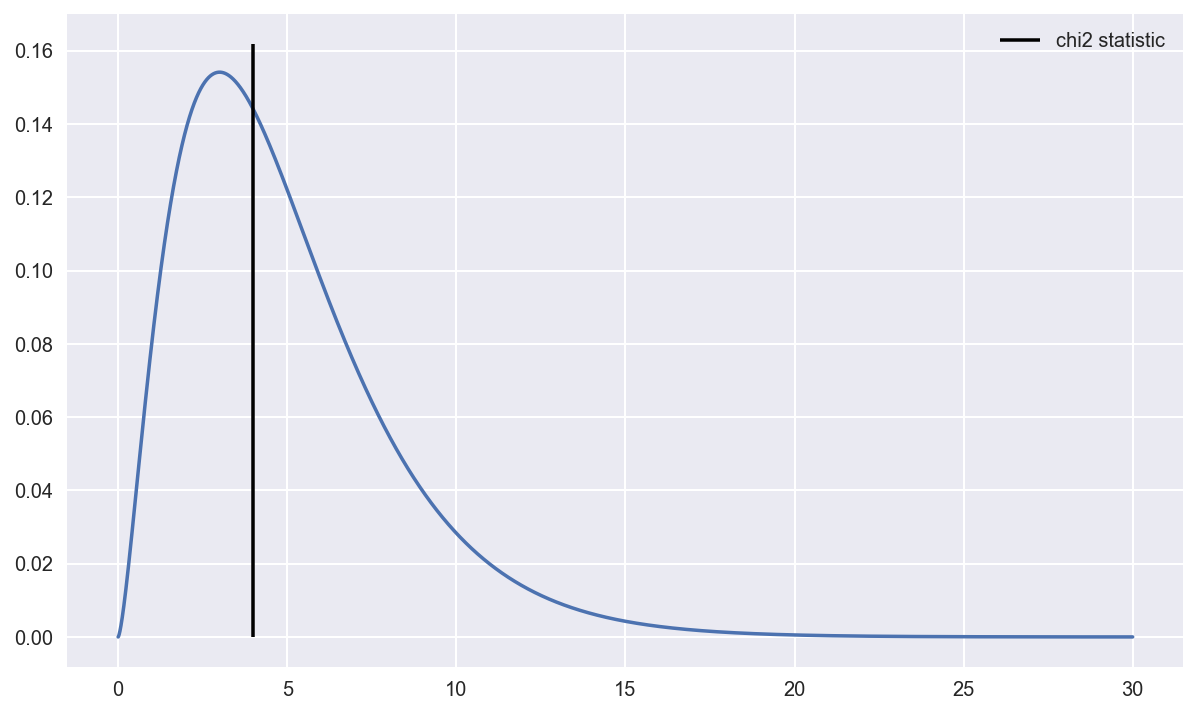

In [6]:
# plot Chi-square distribution with 5 degrees of freedom
plt.plot(x, chi2.pdf(x, df=5));
plt.vlines(chi2_stat, ymin=0, ymax=plt.ylim()[1], color='k', label='chi2 statistic')
plt.legend();

The test statistic seems to fall well within the distribution, i.e. it does not seem to be an unusual event. Indeed, the question we want to answer is: "*under the null hypothesis that the dice is fair, how unlikely is the statistic we have observed?*".

The last component we need in order to build a hypothesis test is a level of confidence, i.e. a threshold of "unlikeliness" of an event, below which we declare that the event is too unlikely under the model, for the model to be true. Let's say we decide to set that threshold at 5%. 

If the likelihood of observing an even that (or more) extreme than the one we have actually observed is less than 5%, we reject the null hypothesis that the dice is fair.

What is this value for a chi-squared distribution with 5 degrees of freedom?

In [7]:
# Compute the Percent Point Function of the chi-squared distribution
z95 = chi2.ppf(0.95, df=5)
z95

11.070497693516351

Since our value is smaller, we do not reject the null.

We can plot the rejection and non-rejection areas in a plot.

In [8]:
# Visualize test
def plot_test(x, stat, df):
    z95 = chi2.ppf(0.95, df=df)
    chi2_pdf = chi2.pdf(x, df=df)
    plt.plot(x, chi2_pdf);
    plt.fill_between(x[x>z95], chi2_pdf[x>z95], color='r', alpha=0.4, label='rejection area')
    plt.fill_between(x[x<z95], chi2_pdf[x<z95], color='g', alpha=0.4, label='non-rejection area')
    plt.vlines(chi2_stat, ymin=0, ymax=plt.ylim()[1], color='k', label='chi2 statistic')
    plt.legend();

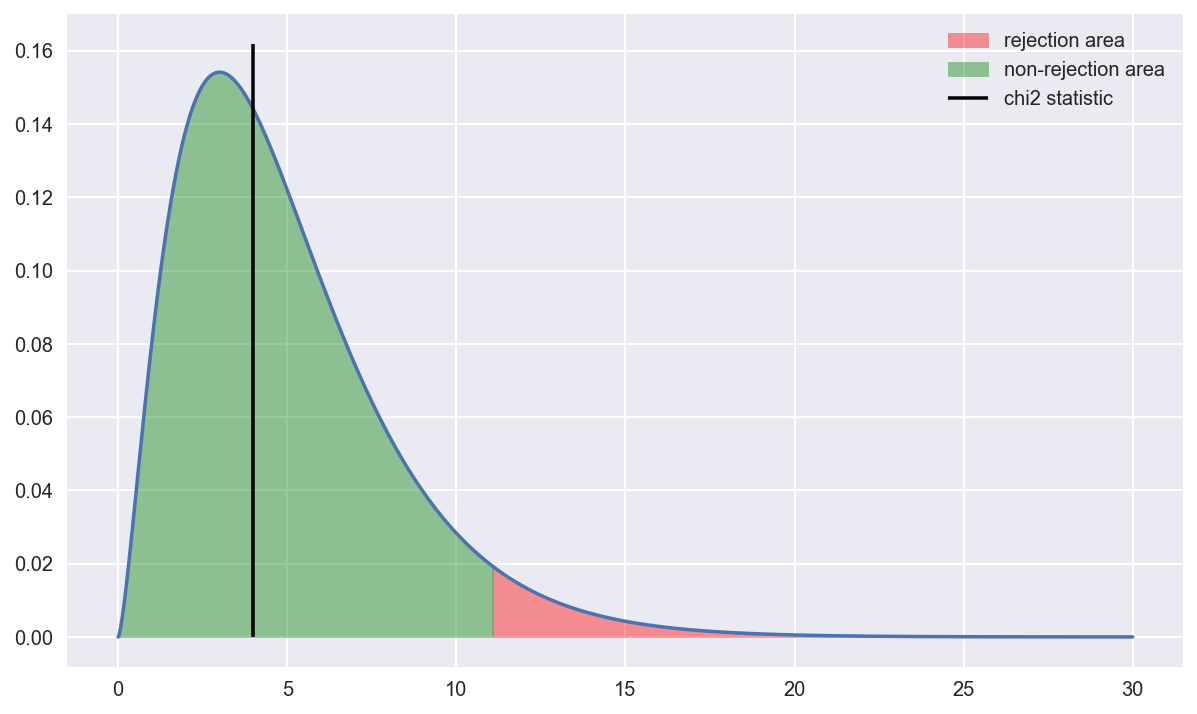

In [9]:
# Plot
plot_test(x, chi2_stat, 5)

From the plot, we can clearly see that we do not reject the null hypothesis that the dice is fair.

## Why the Chi-squared Distribution?

How do we know that that particular statistic has that particular distribution? 

Before digging into the math, we can check this claim via **simulation**. We will repeat the procedure above many times, i.e.

 - roll a (fair) dice 60 times
 - compute the chi-square statistic
 
and then plot the distribution of chi square statistics.

In [10]:
# Function to simulate data and compute chi2 stats
def simulate_chi2stats(K, N, dgp):
    chi2_stats = []
    for i in range(K):
        data = dgp()
        chi2_stats += [compute_chi2_stat(data)]
    return np.array(chi2_stats)

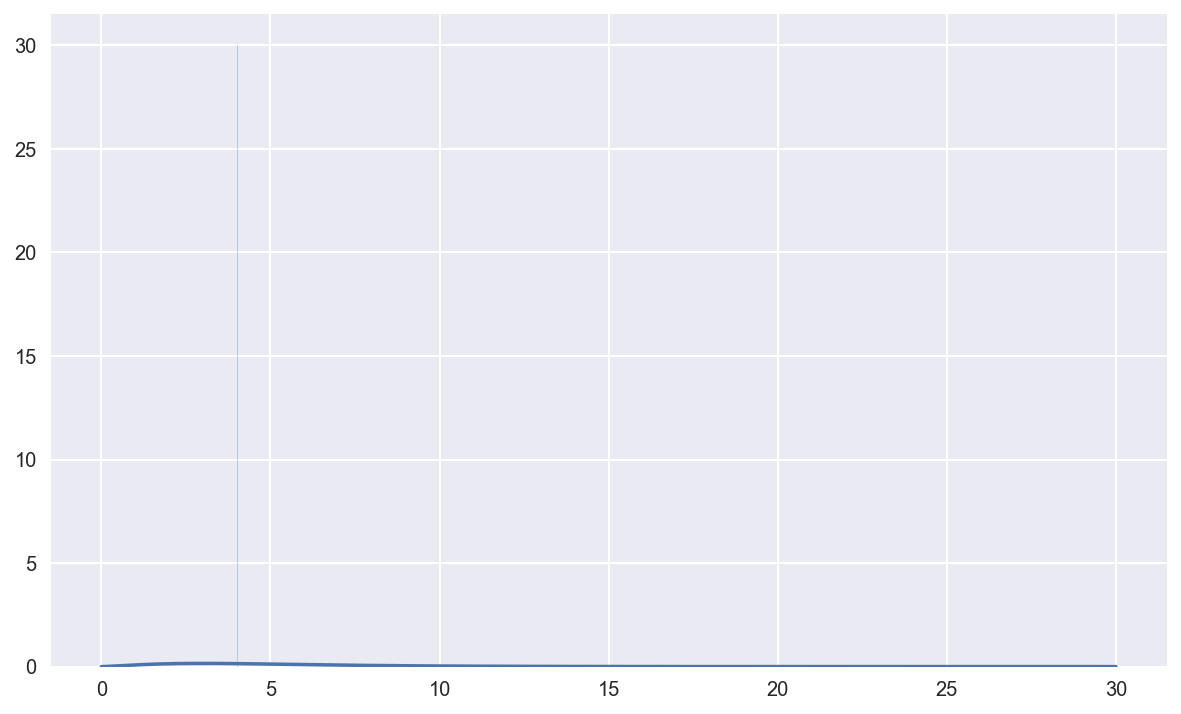

In [11]:
chi2_stats = simulate_chi2stats(K=100, N=60, dgp=generate_data_dice)

# Plot data
plt.hist(chi2_stats, density=True, bins=30, alpha=0.3, color='C0');
plt.plot(x, chi2_5_pdf);

Since we only did it 100 times, the distribution looks pretty coarse but vaguely close. Let's now try 1000 times.

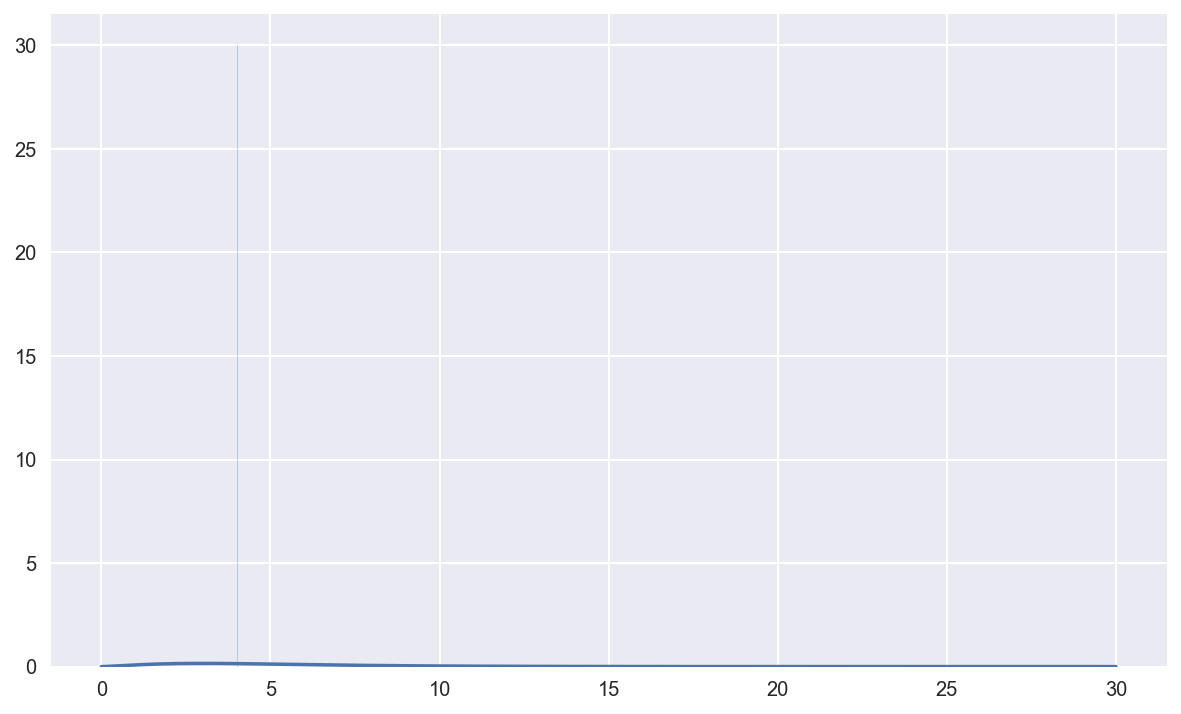

In [12]:
chi2_stats = simulate_chi2stats(K=1000, N=60, dgp=generate_data_dice)

# Plot data
plt.hist(chi2_stats, density=True, bins=30, alpha=0.3, color='C0');
plt.plot(x, chi2_5_pdf);

The empirical distribution of the test statistic is indeed very close to its theoretical counterpart.

## Some Statistics

Why does the distribution of the test statistic look like that? Let's now dig deeper into the math.

There are two things we need to know in order to understand the answer:

- the Central Limit Theorem
- the relationship between a chi-squared and a normal distribution

The [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) says that

> In probability theory, the central limit theorem (CLT) establishes that, in many situations, when independent random variables are summed up, their properly normalized sum tends toward a normal distribution (informally a bell curve) even if the original variables themselves are not normally distributed.

Where does a normal distribution come up in our case? If we look at a single row in our data, i.e. the occurrences of a specific dice throw, it can be interpreted as the sum of realization from a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with probability 1/6.

> In probability theory and statistics, the Bernoulli distribution is the discrete probability distribution of a random variable which takes the value $1$ with probability $p$ and the value $0$ with probability $q=1-p$.

In our case, the probability of getting a particular number is exactly 1/6. What is the distribution of the sum of its realizations? The Central Limit Theorem also tells us that:

> If $X_1, X_2, \dots , X_n, \dots$ are random samples drawn from a population with overall mean $\mu$ and finite variance $\sigma^2$, and if $\bar X_n$ is the sample mean of the first $n$ samples, then the limiting form of the distribution, 
>
>$$
Z = \lim_{n \to \infty} \sqrt{n} \left( \frac{\bar X_n - \mu }{\sigma} \right) 
$$
>
> is a standard normal distribution.

Therefore, in our case, the distribution of the sum of Bernoulli distributions with mean $p$ is distributed as a normal distribution with 

- mean $p$
- variance $p * (1-p)$

Therefore, we can obtain a random variable that is asymptotically standard normal distributed as

$$
\lim_{n \to \infty} \ \sqrt{n} \left( \frac {\bar X_n - p}{\sqrt{p * (1-p)}} \right) \sim N(0,1)
$$

Our last piece: what is a [chi-squared distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution)?

> If $Z_1, ..., Z_k$ are independent, standard normal random variables, then the sum of their squares,
>
>$$
Q = \sum_{i=1}^k Z_i^2
$$
>is distributed according to the chi-squared distribution with $k$ degrees of freedom. 

I.e. the sum of standard normal distributions is a chi-squared distribution, where the **degrees of freedom** indicate the number of normal distributions we are summing over. Since the normalized sum of realizations of each dice number should converge to a standard normal distribution, their sum of squares should converge to a chi-squared distribution. I.e.

$$
\lim_{n \to \infty} \ \sum_k n \frac{(\bar X_n - p)^2}{p * (1-p)} \sim \chi^2_k
$$

There is just one issue: the last distribution is not really independent from the others. In fact, as soon as we know that we have thrown 60 dices and how many 1s, 2s, 3s, 4s, and 5s we got, we can compute the number of 6s. Therefore, we should exclude one distribution since only 5 (or, in general, $k-1$) are truly independent. 

In practice, however, we sum all distributions, but then we scale them down by multiplying them by $(1-p)$ so that we have

$$
\lim_{n \to \infty} \ \sum_k n \frac{(\bar X_n - p)^2}{p} \sim \chi^2_{k-1}
$$

which is exactly the formula we used to compute the test statistic:

$$
T_{\chi^2} = \sum _{i=1}^{n} \frac{(O_i - E_i)^{2}}{E_i} = N \sum _{i=1}^{n} \frac{\left(O_i/N - p_i \right)^2 }{p_i}
$$

## Example 2: are grades independent from gender?

Chi-squared tests can also be used to test independence between 2 variables. The idea is fundamentally the same as the test in the previous section: checking systematic differences between observed and expected values, across different variables.

Suppose you have data on grades in a classroom, by gender. Grades go from $1$ to $4$. Assuming males and females are equally prepared for the test, you want to test whether there has been discrimination in grading.

The problem is again asserting whether the observed differences are random or systematic.

Let's generate some data (under the no discrimination assumption).

In [13]:
# Data generating process for grades
def generate_data_grades(N_male=60, N_female=40):
    grade_scale = [1,2,3,4]
    p = [0.1, 0.2, 0.5, 0.2]
    grades_male = np.random.choice(grade_scale, size=N_male, p=p)
    grades_female = np.random.choice(grade_scale, size=N_female, p=p)
    data = pd.DataFrame({"grade": grade_scale + grade_scale,
                          "gender": ["male" for i in grade_scale] + ["female" for i in grade_scale],
                          "observed": [sum(grades_male==n) for n in grade_scale] + [sum(grades_female==n) for n in grade_scale],
                        })  
    data['expected gender'] = data.groupby("gender")["observed"].transform("mean") 
    data['expected grade'] = data.groupby("grade")["observed"].transform("mean") 
    data['expected'] = data['expected gender'] * data['expected grade'] / data['observed'].mean()
    return data

In [14]:
# Set seed for replicability
np.random.seed(1)

# Generate data
data_grades = generate_data_grades()
data_grades

,grade,gender,observed,expected gender,expected grade,expected
0,1,male,9,15.0,5.5,6.6
1,2,male,14,15.0,10.5,12.6
2,3,male,27,15.0,24.5,29.4
3,4,male,10,15.0,9.5,11.4
4,1,female,2,10.0,5.5,4.4
5,2,female,7,10.0,10.5,8.4
6,3,female,22,10.0,24.5,19.6
7,4,female,9,10.0,9.5,7.6


Has there been discrimination?

The value of the test-statistic is

$$
T_{\chi^2} = \sum_{i=1}^r \sum_{j=1}^c \frac{(O_{i,j} - E_{i,j})^2 }{ E_{i,j} } = N \sum_{i,j} p_{i \cdot} p_{\cdot j} \left( \frac{O_{i,j}/N - p_{i \cdot} p_{\cdot j} }{ p_{i \cdot} p_{\cdot j}} \right)^2
$$

where

- $N$ is the total sample size (the sum of all cells in the table)

- $p_{i \cdot} = \frac{O_{i\cdot }}{N} = \sum_{j=1}^{c} \frac{O_{i,j}}{N}$ is the fraction of observations of type i ignoring the column attribute (fraction of row totals), and

- $p_{\cdot j} = \frac{O_{\cdot j}}{N} = \sum_{i=1}^{r} \frac{O_{i,j}}{N}$ is the fraction of observations of type j ignoring the row attribute (fraction of column totals).

So the formula for the test statistic is the same

In [15]:
chi2_stat = compute_chi2_stat(data_grades)
chi2_stat

3.490327550477927

As before, we can double-check whether the statistic is indeed distributed as a chi-squared with $k-1$ degrees of freedom by simulating the data generating process.

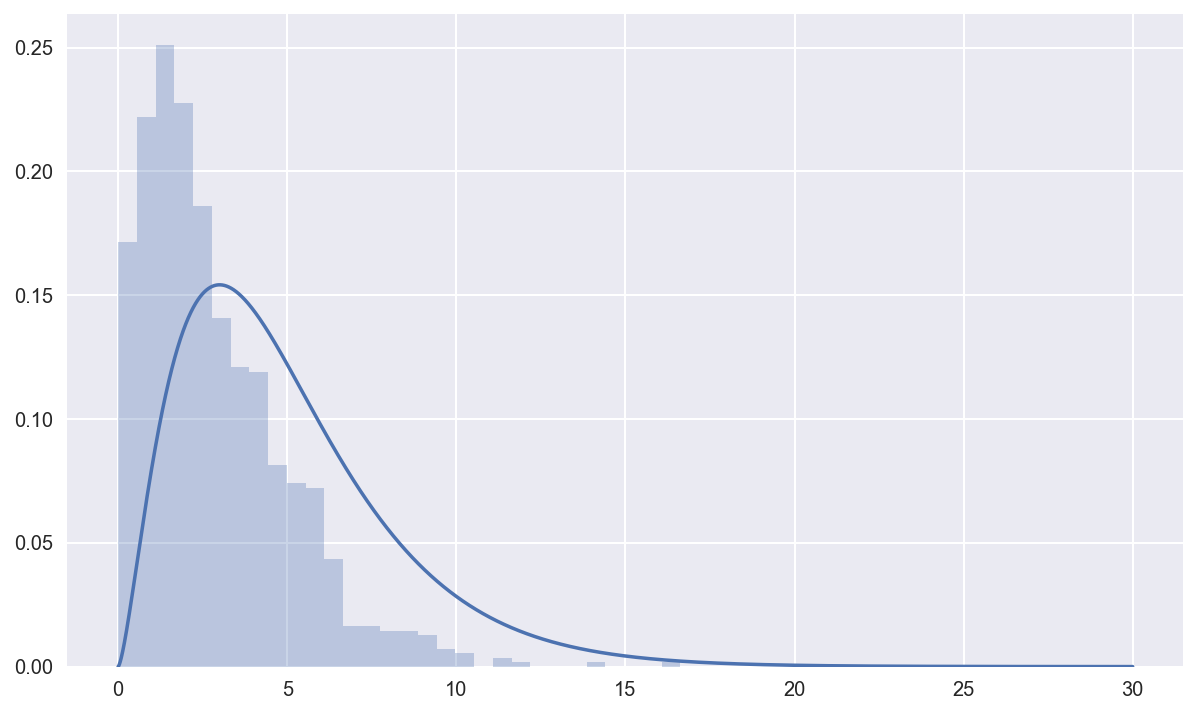

In [16]:
# Plot data
chi2_stats = simulate_chi2stats(K=1000, N=60, dgp=generate_data_grades)
plt.hist(chi2_stats, density=True, bins=30, alpha=0.3, color='C0');
plt.plot(x, chi2_5_pdf);

What happened? We forgot to change the degrees of freedom! The general formula for the degrees of freedom when testing the independence of variables is $(N_i - 1) \times (N_j - 1)$. So in our case, it's $(4-1) \times (2-1) = 3$.

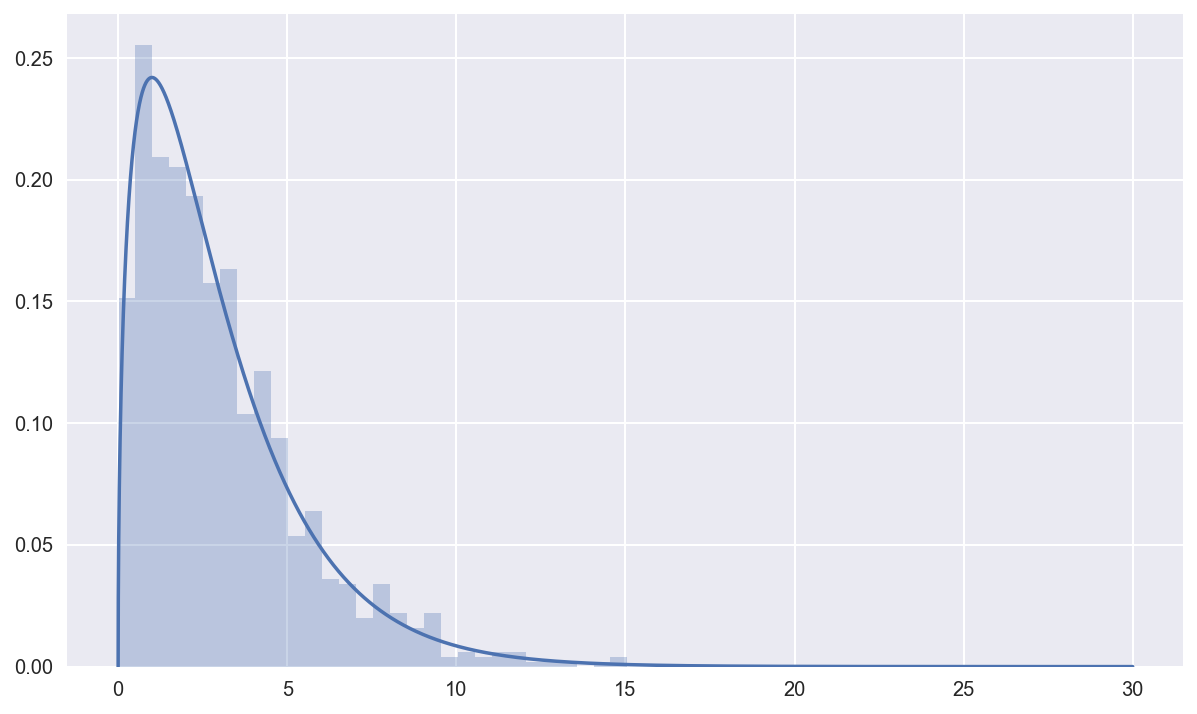

In [17]:
chi2_3_pdf = chi2.pdf(x, df=3)

# Plot data
chi2_stats = simulate_chi2stats(K=1000, N=60, dgp=generate_data_grades)
plt.hist(chi2_stats, density=True, bins=30, alpha=0.3, color='C0');
plt.plot(x, chi2_3_pdf);

Do we reject the null hypothesis of independent distributions of gender and grades?

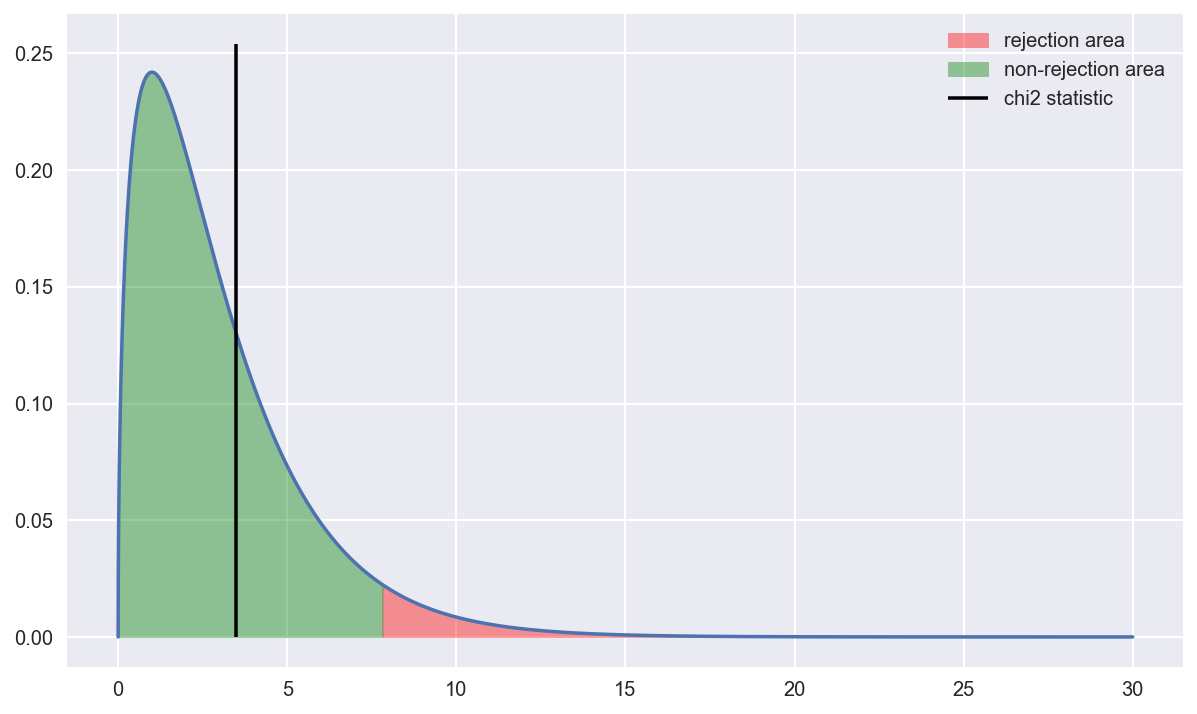

In [18]:
# Plot
plot_test(x, chi2_stat, df=3)

No, we **do not reject** the null hypothesis of independend distributions of gender and grades.

## Example 3: testing a specific data generating process

As we have seen, the chi-square test can be used to compare observed means/frequencies against a null hypothesis. How can we use this statistic to **test a distributional assumption**? 

The answer is simple: we can construct conditional means. The easiest way to do it is to bin the data into equally sized bins and then check if the observed frequencies match the expected probabilities. 

**Note**: we don't need to have equally sized bins, but it's useful since it ensures that we have as many observations in each bin as possible.

In [19]:
from scipy.stats import expon

# Data generating process
def generate_poisson_data(N=60, cuts=4):
    poisson_draws = np.random.exponential(size=N)
    cat, bins = pd.qcut(poisson_draws, cuts, retbins=True)
    p = [expon.cdf(bins[n+1]) - expon.cdf(bins[n]) for n in range(len(bins)-1)]
    data = pd.DataFrame({"bin": cat.unique(),
                         "observed": [sum(cat==n) for n in cat.unique()],
                         "expected": np.dot(p, N)})
    return data, poisson_draws

In [20]:
# Set seed for replicability
np.random.seed(2)

# Generate data
data_poisson, poisson_draws = generate_poisson_data()
data_poisson

,bin,observed,expected
0,"(0.254, 0.573]",15,11.919795
1,"(0.0253, 0.254]",15,12.706904
2,"(0.573, 0.923]",15,9.967649
3,"(0.923, 5.092]",15,23.481200


We can also plot the observed and realized distribution of the data.

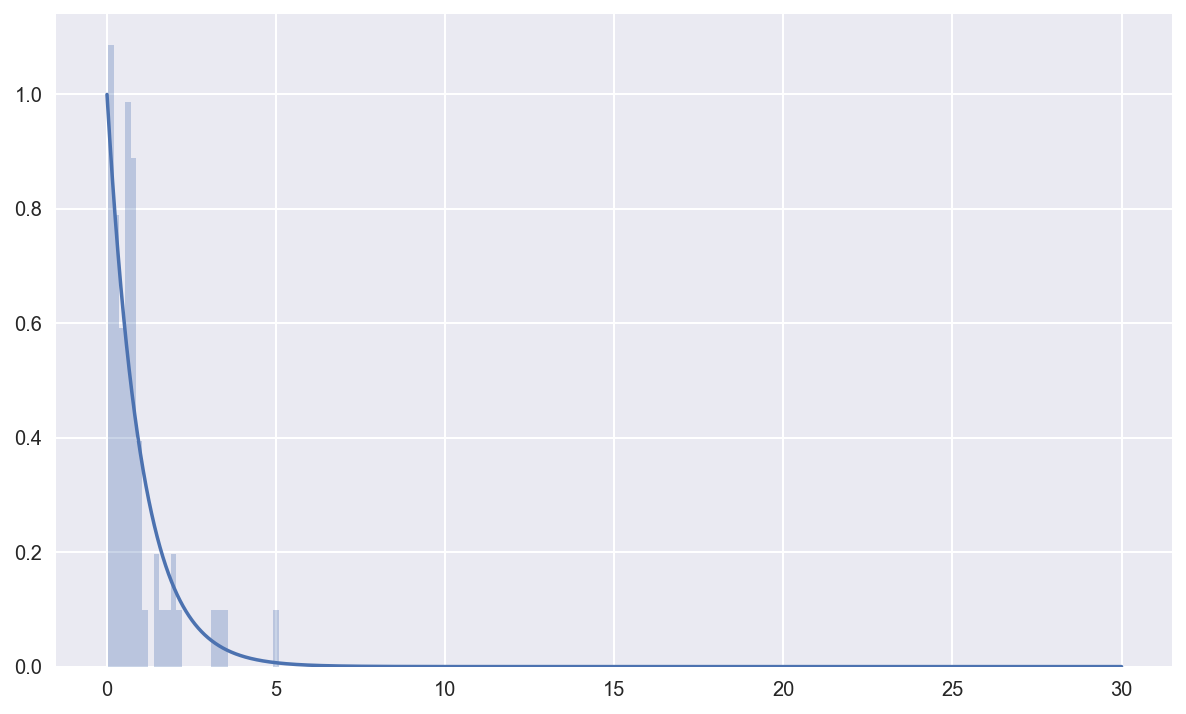

In [21]:
# Plot data
plt.hist(poisson_draws, density=True, bins=30, alpha=0.3, color='C0');
exp_pdf = expon.pdf(x)
plt.plot(x, exp_pdf);

The two distributions seem close but we need a test statistic in order to assess whether the dgp is indeed an exponential distribution

In [22]:
chi2_stat = compute_chi2_stat(data_poisson)
chi2_stat

6.813781416601728

Do we reject the null hypothesis that the data is drawn from an exponential distribution?

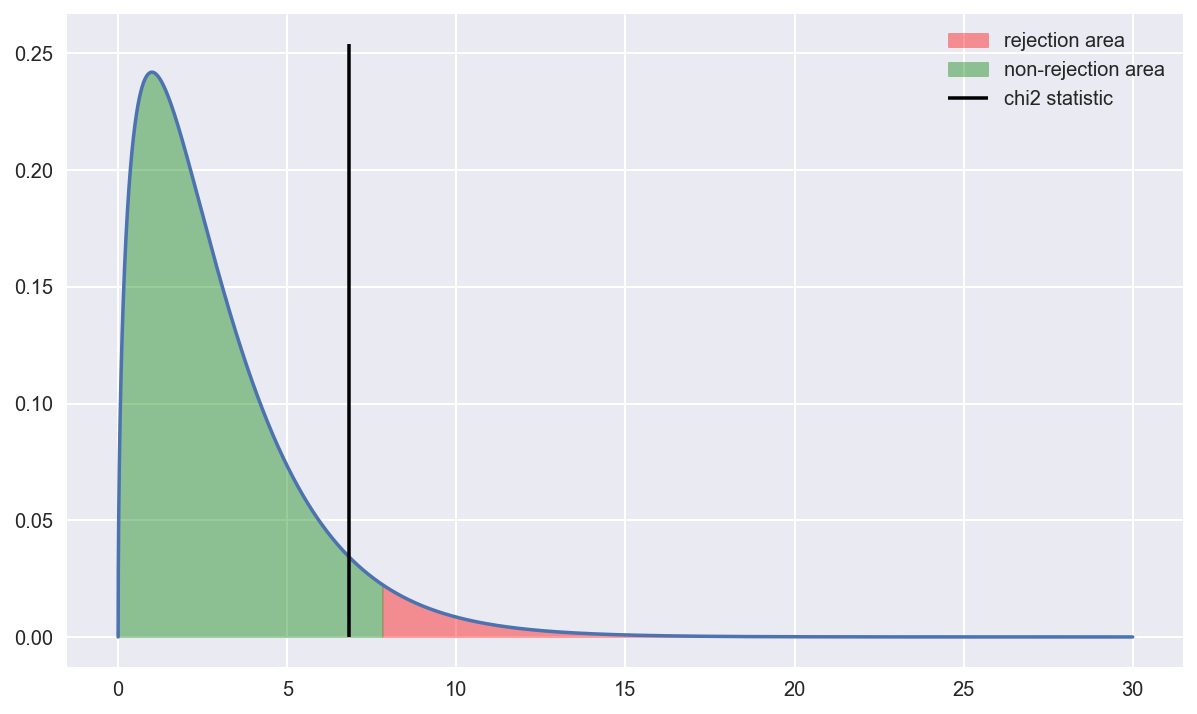

In [23]:
# Plot
plot_test(x, chi2_stat, df=3)

No, we **do not reject** the null hypothesis that the data is drawn from an exponential distribution.

## Conclusion

In this tutorial, we have seen how to perform 3 hypoteses tests

1. testing if a set of means or sums is coming from the expected distribution
2. testing if two distributions are independent or not
3. testing a specific data generating process

The underlying principle is the same: testing discrepancies between expected and observed count data. 

The key statistic is Pearson's chi-square statistic and the key distribution is the chi-squared distribution. We have seen how to compute the statistic, why it has a chi-squared distribution, and how to use this information to perform a statistical hypothesis test.